In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [3]:
synapse_params = {"g12": 0.35, "g23": 0.27, "g32": 0.215, "g31": 0.203}
# synapse_params = {"g12": 0.35, "g23": 0.27, "g32": 0.215, "g31": 0.203}

class neuron():
    def __init__(self) -> None:
        self.C = 1.0 # neuron capacitance
        self.gn = 120.0 # maximum Na conductance
        self.vna = 50.0 # Na reversal potential
        self.gk = 20.0 # maximum K conductance
        self.vk = -77.0 # K reversal potential
        self.gl = 0.3  # maximum leak condunctance
        self.vl = -54.4 # leak reversal potential

        # parameters used in the dynamics of the subunits of the ion channels
        self.vm, self.dvm = -40.0, 15.0
        self.tm0, self.tm1 = 0.1, 0.4
        self.vn, self.dvn = -55.0, 30.0
        self.tn0, self.tn1 = 1.0, 5.0
        self.vh, self.dvh  = -60.0, -15.0
        self.th0, self.th1 = 1.0, 7.0

        # parameters used in the dynamics of synapses
        self.v0, self.dv0 = -5.0, 5.0
        self.S1, self.S2 = 3.0/2.0, 5.0/3.0
        self.tau1, self.tau2 = 1.0, 3.0
        self.Ereve, self.Erevi = 0.0, -80.0

    def HH_intrinsic(self, V, m, h, n):
        """Output is the contribution to the current (positive direction is from outside to inside of the neuron) from the intrinsic dynamics of Huxley-Hodgley neuron"""
        i_Na = self.gn*(m**3)*h*(self.vna - V)
        i_K = self.gk*(n**4)*(self.vk - V)
        i_L = self.gl*(self.vl - V)
        return i_Na + i_K + i_L

    def _g_fun(self, V, A, B):
        """Used in the dynamics of subunits of ion channels"""
        return 0.5*(1+np.tanh((V-A)/B))

    def _tau_fun(self, V, t0, t1, A, B):
        """Used in the dynamics of subunits of ion channels"""
        return t0+t1*(1.0 - np.tanh((V-A)/B)**2)

    def _S0(self, V):
        """Used in the dynamics of synapses"""
        return self._g_fun(V, self.v0, self.dv0)

    def dmdt(self, V, m):
        """dm/dt"""
        return (self._g_fun(V, self.vm, self.dvm) - m)/self._tau_fun(V, self.tm0, self.tm1, self.vm, self.dvm)

    def dndt(self, V, n):
        """dn/dt"""
        return (self._g_fun(V, self.vn, self.dvn) - n)/self._tau_fun(V, self.tn0, self.tn1, self.vn, self.dvn)
    
    def dhdt(self, V, h):
        """dh/dt"""
        return (self._g_fun(V, self.vh, self.dvh) - h)/self._tau_fun(V, self.th0, self.th1, self.vh, self.dvh)

    def dSedt(self, V_pre, Se):
        """dSe/dt"""
        s0 = self._S0(V_pre)
        return (s0 - Se)/self.tau1/(self.S1 - s0)

    def dSidt(self, V_pre, Si):
        """dSi/dt"""
        s0 = self._S0(V_pre)
        return (s0 - Si)/self.tau2/(self.S2 - s0)


def dfdt(state, t, params):
    """
    df/dt;
    state = [V1, m1, h1, n1, V2, m2, h2, n2, V3, m3, h3, n3, S31, S12, S32, S23];
    params = {"g12":....}
    """
    neuron1 = neuron()
    neuron2 = neuron()
    neuron3 = neuron()
    def i_stim2(t):
        return 10
    def i_stim3(t):
        return 100
    V1, m1, h1, n1, V2, m2, h2, n2, V3, m3, h3, n3, S31, S12, S32, S23 = state
    dV1dt = (neuron1.HH_intrinsic(V1, m1, h1, n1) + params["g12"]*S12*(neuron1.Ereve - V1))/neuron1.C
    dV2dt = (neuron2.HH_intrinsic(V2, m2, h2, n2) + params["g23"]*S23*(neuron2.Ereve - V2) + i_stim2(t))/neuron2.C
    dV3dt = (neuron3.HH_intrinsic(V3, m3, h3, n3) + params["g32"]*S32*(neuron3.Erevi - V3) + params["g31"]*S31*(neuron3.Erevi - V3)+ i_stim3(t))/neuron3.C
    dm1dt, dh1dt, dn1dt = neuron1.dmdt(V1, m1), neuron1.dhdt(V1, h1), neuron1.dndt(V1, n1)
    dm2dt, dh2dt, dn2dt = neuron2.dmdt(V2, m2), neuron2.dhdt(V2, h2), neuron2.dndt(V2, n2)
    dm3dt, dh3dt, dn3dt = neuron3.dmdt(V3, m3), neuron3.dhdt(V3, h3), neuron3.dndt(V3, n3)
    dS31dt = neuron1.dSidt(V1, S31)
    dS12dt = neuron2.dSedt(V2, S12)
    dS32dt = neuron2.dSidt(V2, S32)
    dS23dt = neuron3.dSedt(V3, S23)
    return [dV1dt, dm1dt, dh1dt, dn1dt, dV2dt, dm2dt, dh2dt, dn2dt, dV3dt, dm3dt, dh3dt, dn3dt, dS31dt, dS12dt, dS32dt, dS23dt]

In [4]:
t_list = np.arange(0, 100, 0.01)
state0 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
sol = odeint(dfdt, state0, t_list, (synapse_params, ))

Text(0, 0.5, 'voltage (mV)')

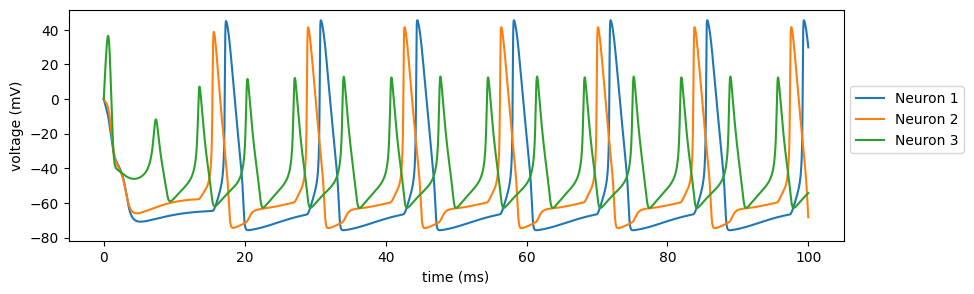

In [5]:
plt.figure(figsize=(10, 3))
for i in range(3):
    plt.plot(t_list[:], sol[:, 4*i], label=f"Neuron {i+1}")
plt.legend(bbox_to_anchor=(1, 0.7))
plt.xlabel("time (ms)")
plt.ylabel("voltage (mV)")

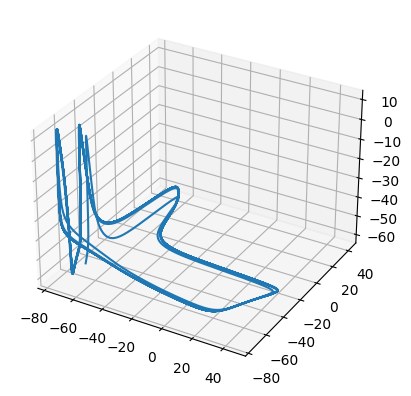

In [6]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(sol[1000:, 0], sol[1000:, 4], sol[1000:, 8])

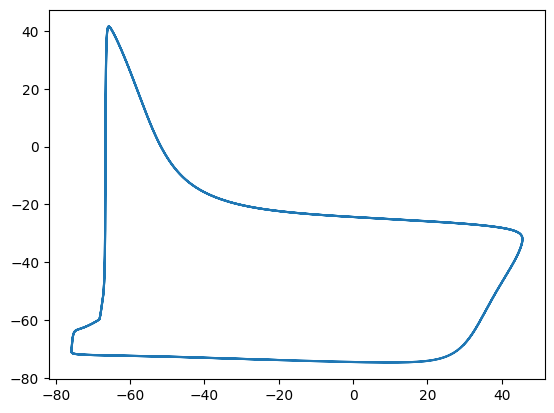

In [7]:
plt.plot(sol[6000:, 0], sol[6000:, 4])